# Weight Pruning

https://www.tensorflow.org/model_optimization/guide/pruning/comprehensive_guide.md

https://www.tensorflow.org/model_optimization/guide/pruning/pruning_with_keras



In [8]:
# !python3 -m pip uninstall PyYAML -y
# !python3 -m pip install PyYAML==6.0
# # !python3 -m pip show pyyaml
# # !python3 -m pip show tensorflow
# !python3 -m pip uninstall tensorflow-model-optimization -y
# !python3 -m pip install --upgrade tensorflow-model-optimization==0.6.0

Found existing installation: PyYAML 5.1
Uninstalling PyYAML-5.1:
  Successfully uninstalled PyYAML-5.1
  Using cached PyYAML-6.0-cp36-cp36m-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (603 kB)
Name: PyYAML
Version: 6.0
Summary: YAML parser and emitter for Python
Home-page: https://pyyaml.org/
Author: Kirill Simonov
Author-email: xi@resolvent.net
License: MIT
Location: /usr/local/lib/python3.6/site-packages
Requires: 
Required-by: pyaml


In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../src')
from inferencev2 import *
import pathlib
from IPython.display import display, HTML
import pandas as pd
import os
import json
from inferencev2 import load_trained_jobs
import imageio
from PIL import Image
import numpy as np
from inferencev2 import SampleImage


ROOT = pathlib.Path('/notebooks')
VOLUMES = ROOT / 'code/volumes'
WEIGHTS = VOLUMES / 'checkpoints/weights'

## Load Sample Job for Fine Tuning

In [2]:
def should_include(job):
    params = json.loads(job.get_params())
    dataset = job.get_dataset()
    compress = job.get_compression()
    sharpen = job.get_sharpen()
    return sharpen == '0' and compress == '100' and params.get('C') == '4' and params.get('D') == '3' and params.get('G') == '4' and params.get('G0') == '64' and dataset == 'div2kpreprocessed'

jobs = [j for j in load_trained_jobs(WEIGHTS) if should_include(j)]

job = jobs[0]
model, modelname = job.get_model()
discriminator = job.get_discriminator()
generator = job.get_generator()
print(job.get_model())

(<ISR.models.rrdn.RRDN object at 0x7ffa92d01048>, PosixPath('/notebooks/code/volumes/checkpoints/weights/rrdn-C4-D3-G4-G064-T10-x2-patchsize128-compress100-sharpen0-datadiv2kpreprocessed/2022-04-12_1040/rrdn-C4-D3-G4-G064-T10-x2-patchsize128-compress100-sharpen0-data_epoch300.hdf5'))


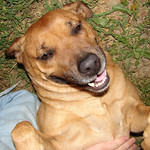

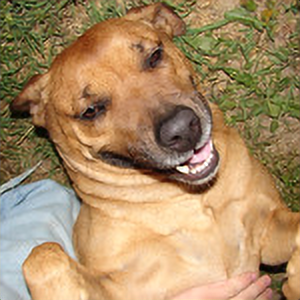

In [3]:
img_path = './sample_images/fundog.jpg'

def show_imageio(im):
    return Image.fromarray((im).astype(np.uint8))

def upscale_img(img_path):
    im = imageio.imread(img_path)
    display(show_imageio(im))
    sr_img = Image.fromarray(model.predict(im))
    display(sr_img)
    
upscale_img(img_path)

In [ ]:
!rm -rf tmp
from WeightPruner import WeightPruner
from ISR.train import Trainer
from ISR.models import RRDN, RDN
from ISR.models import Discriminator
from ISR.models import Cut_VGG19

DATA = pathlib.Path('/notebooks/data/div2k-processed/preprocessed/2x')

lr_train_dir = str(DATA / 'train' / 'lr')
hr_train_dir = str(DATA / 'train' / 'hr')
lr_valid_dir = str(DATA / 'valid' / 'lr')
hr_valid_dir = str(DATA / 'valid' / 'hr')
C = 4
D = 3
G = 4
G0 = 64
x = 2
scale = x
epochs = 301
batches_per_epoch = 20
hr_train_patch_size = 128
batch_size = 16
epsilon = 0.1
beta1 = 0.9
beta2 = 0.999
lr = 0.0004
loss_weight_generator = 1
loss_weight_discriminator = 0.0
loss_weight_feature_extractor = 0.0
lr_decay_factor = 0.5
lr_decay_frequency = 100
n_validation = 100
lr_train_patch_size = int(hr_train_patch_size / scale)
layers_to_extract = [5, 9]
n_validation = 100

f_ext = Cut_VGG19(patch_size=hr_train_patch_size, layers_to_extract=layers_to_extract)
discr = Discriminator(patch_size=hr_train_patch_size, kernel_size=3)

loss_weights = {
    'generator': loss_weight_generator,
    'feature_extractor': loss_weight_feature_extractor,
    'discriminator': loss_weight_discriminator,
}
losses = {
    'generator': 'mae',
    'feature_extractor': 'mse',
    'discriminator': 'binary_crossentropy'
}

learning_rate = {'initial_value': lr, 'decay_factor': lr_decay_factor, 'decay_frequency': lr_decay_frequency}

flatness = {'min': 0.0, 'max': 0.15, 'increase': 0.01, 'increase_frequency': 5}

OUTPUT = pathlib.Path('tmp/weight-pruning')

log_dirs = { 'logs': OUTPUT / 'logs', 'weights': OUTPUT / 'weights' }
generator, _ = job.get_model()
generator.patch_size = lr_train_patch_size
pruner = WeightPruner(
        generator=generator,
        discriminator=discr,
        feature_extractor=f_ext,
        lr_train_dir=lr_train_dir,
        hr_train_dir=hr_train_dir,
        lr_valid_dir=lr_valid_dir,
        hr_valid_dir=hr_valid_dir,
        loss_weights=loss_weights,
        losses=losses,
        learning_rate=learning_rate,
        flatness=flatness,
        dataname='image_dataset',
        log_dirs=log_dirs,
        weights_generator=job.get_generator(),
        weights_discriminator=job.get_discriminator(),
        n_validation=n_validation,
)
print(f'Starting training now for {epochs} epochs')
pruner.train(
    epochs=epochs,
    steps_per_epoch=batches_per_epoch,
    batch_size=batch_size,
    monitored_metrics={
        'val_loss': 'min',
        'val_PSNR_Y': 'max',
        'val_generator_loss': 'min',
        'val_generator_PSNR_Y': 'max',
    },
)
print('Training complete')

********* YES
make_basename is not specified, use our own


100%|██████████| 100/100 [00:00<00:00, 961996.33it/s]

Starting training now for 301 epochs




Training details:
  training_parameters: 
    metrics: {'generator': <function PSNR_Y at 0x7ffaaeb830d0>}
    losses: {'generator': 'mae', 'feature_extractor': 'mse', 'discriminator': 'binary_crossentropy'}
    adam_optimizer: {'beta1': 0.9, 'beta2': 0.999, 'epsilon': None}
    learning_rate: {'initial_value': 0.0004, 'decay_factor': 0.5, 'decay_frequency': 100}
    flatness: {'min': 0.0, 'max': 0.15, 'increase': 0.01, 'increase_frequency': 5}
    n_validation: 100
    dataname: image_dataset
    fallback_save_every_n_epochs: 2
    log_dirs: {'logs': PosixPath('tmp/weight-pruning/logs'), 'weights': PosixPath('tmp/weight-pruning/weights')}
    loss_weights: {'generator': 1, 'feature_extractor': 0.0, 'discriminator': 0.0}
    hr_valid_dir: /notebooks/data/div2k-processed/preprocessed/2x/valid/hr
    lr_valid_dir: /notebooks/data/div2k-processed/preprocessed/2x/valid/lr
    hr_train_dir: /notebooks/data/div2k-processed/preprocessed/2x/train/hr
    lr_train_dir: /notebooks/data/div2k-pro

/notebooks/code/volumes/checkpoints/weights/rrdn-C4-D3-G4-G064-T10-x2-patchsize128-compress100-sharpen0-datadiv2kpreprocessed/2022-04-12_1040/session_config.yml
Instructions for updating:
Please use `layer.add_weight` method instead.
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
generator (Model)               multiple             3463943     input_3[0][0]                    
__________________________________________________________________________________________________
discriminator (Model)           (None, 32, 32, 1)    10427942    generator[1][0]                  
________________________________________________________

In [ ]:
import tempfile
import tensorflow as tf
import tensorflow_model_optimization as tfmot

model_for_export = tfmot.sparsity.keras.strip_pruning(pruner.model_for_pruning)

_, pruned_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)
print('Saved pruned Keras model to:', pruned_keras_file)


In [ ]:
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)


converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
pruned_tflite_model = converter.convert()

_, pruned_tflite_file = tempfile.mkstemp('.tflite')

with open(pruned_tflite_file, 'wb') as f:
  f.write(pruned_tflite_model)

print('Saved pruned TFLite model to:', pruned_tflite_file)


print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(keras_file)))
print("Size of gzipped pruned Keras model: %.2f bytes" % (get_gzipped_model_size(pruned_keras_file)))
print("Size of gzipped pruned TFlite model: %.2f bytes" % (get_gzipped_model_size(pruned_tflite_file)))


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_and_pruned_tflite_model = converter.convert()

_, quantized_and_pruned_tflite_file = tempfile.mkstemp('.tflite')

with open(quantized_and_pruned_tflite_file, 'wb') as f:
  f.write(quantized_and_pruned_tflite_model)

print('Saved quantized and pruned TFLite model to:', quantized_and_pruned_tflite_file)

print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(keras_file)))
print("Size of gzipped pruned and quantized TFlite model: %.2f bytes" % (get_gzipped_model_size(quantized_and_pruned_tflite_file)))


In [36]:
pruner.model

In [40]:
import tensorflow as tf
import tensorflow_model_optimization as tfmot
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 128
epochs = 2
validation_split = 0.1 # 10% of training set will be used for validation set. 


# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=100)
}

model_for_pruning = prune_low_magnitude(pruner.model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_for_pruning.summary()


Model: "model_51"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_33 (InputLayer)           [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
generator (Model)               multiple             3463943     input_33[0][0]                   
__________________________________________________________________________________________________
discriminator (Model)           (None, 32, 32, 1)    10427942    generator[1][0]                  
__________________________________________________________________________________________________
feature_extractor (Model)       [(None, 64, 64, 128) 3469840     generator[1][0]                  
Total params: 17,361,725
Trainable params: 1,732,928
Non-trainable params: 15,628,797
_____

In [42]:
import tempfile
logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

model_for_pruning.fit(train_images, train_labels,
                  batch_size=batch_size, epochs=epochs, validation_split=validation_split,
                  callbacks=callbacks)


NameError: name 'train_images' is not defined